In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cluster import OPTICS

from utils.denoise import *
from utils.data_io import *
from utils.plot import *

In [2]:
# path_str = input("请输入文件路径：")


path_str = "processed_ATL03_20221230185202_01561807_006_02_gt3r_cut.csv"
data_path = Path(path_str)

assert data_path.exists(), "文件不存在"

df = None

with open(data_path, 'r') as f:
    df = pd.read_csv(f)
    
print(df.columns)

df["point_type"] = PointType.NotClassified.value
print(df["point_type"].dtypes)

Index(['Unnamed: 0', 'Time (sec)', 'Delta Time (sec)', 'Segment ID', 'GT Num',
       'Beam Num', 'Beam Type', 'Latitude (deg)', 'Longitude (deg)',
       'UTM Easting (m)', 'UTM Northing (m)', 'UTM Zone', 'UTM Hemisphere',
       'Cross-Track (m)', 'Along-Track (m)', 'Height (m HAE)',
       'Height (m MSL)', 'Classification', 'Signal Confidence',
       'Solar Elevation (deg)'],
      dtype='object')
int64


In [3]:
sea_level, water_surface = get_sea_level(df, n_sigmas=0.8)

print(f"sea_level: {sea_level}, limit: {water_surface}")

df.loc[
    (df["Height (m MSL)"] > water_surface[0])
    & (df["Height (m MSL)"] < water_surface[1]),
    "point_type",
] = PointType.WaterSurface.value

df.loc[(df["Height (m MSL)"] >= water_surface[1]), "point_type"] = PointType.Noise.value

sea_level: 0.8073118184511227, limit: (0.5446190736047178, 1.0700045632975275)


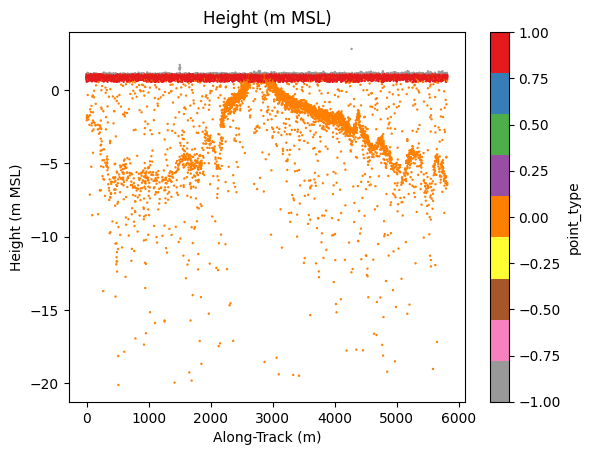

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Height (m MSL)'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [4]:
# 筛选出高度低于水面的数据
underwater_mask = df["Height (m MSL)"] < water_surface[0]

# 获取需要调整高度的数据列
under_water_point = df.loc[underwater_mask, "Height (m MSL)"]

# 调整高度
real_depth = under_water_point.apply(get_real_depth, args=(sea_level,))

# 将调整后的高度赋值回原数据框
df.loc[underwater_mask, "Height (m MSL)"] = sea_level - real_depth

get_plt(df)

样本数量：4137
有效点数量：4137
噪声点数量：0
有效点比例：1.0
噪声点比例：0.0


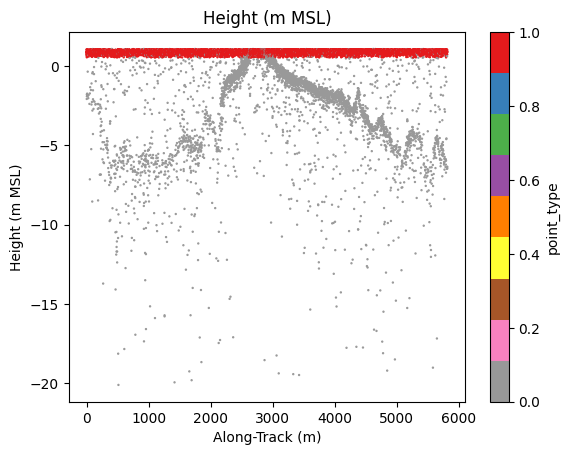

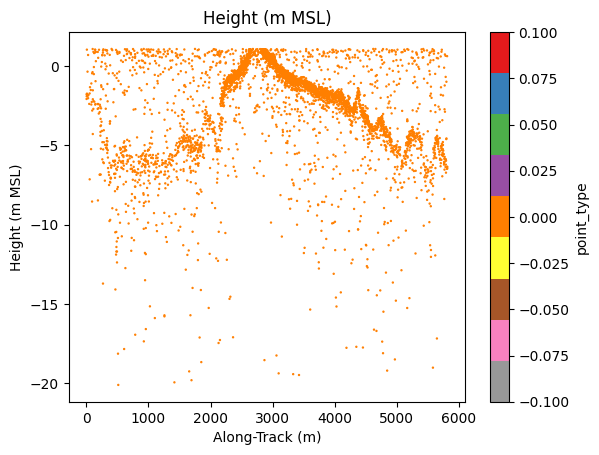

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Height (m MSL)'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [ ]:
# optics_clustering_denoise的效果更好
under_water_point = df.loc[underwater_mask].copy()
noise_points = optics_clustering_denoise(under_water_points=under_water_point)
original_indices = under_water_point.index[noise_points]
df.loc[original_indices, "point_type"] = PointType.Noise.value

# land_points = np.logical_not(noise_points)
# original_indices = under_water_point.index[land_points]
# df.loc[original_indices, "point_type"] = PointType.LandSurface.value

# get_plt(df)
# get_plt(df.loc[underwater_mask])

# under_water_point = df.loc[underwater_mask].copy()
# noise_points = dbscan_denoise(under_water_points=under_water_point, eps=8, min_samples=10)
# original_indices = under_water_point.index[noise_points]
# df.loc[original_indices, "point_type"] = PointType.Noise.value
# get_plt(df)

# under_water_point = df.loc[underwater_mask].copy()
# noise_points = adaptive_elliptical_denoise(under_water_points=under_water_point,k=3,alpha=0.1)
# original_indices = under_water_point.index[noise_points]
# df.loc[original_indices, "point_type"] = PointType.Noise.value
# get_plt(df)

# under_water_point = df.loc[underwater_mask].copy()
# noise_points = adaptive_optics_denoise(under_water_point, eps=1)
# original_indices = under_water_point.index[noise_points]
# df.loc[original_indices, "point_type"] = PointType.Noise.value
# get_plt(df)
# get_plt(df.loc[underwater_mask])

In [6]:
df = df.loc[df["point_type"] != PointType.Noise.value]

save_csv(df, data_path, "denoise", True)

UnboundLocalError: local variable 'filename' referenced before assignment